# ECAI Tutorial 17: A Gentle intro to Quantum Machine Learning

Dr. Steve Campbell and Dr. Simon Caton 

UCD Centre for Quantum Engineering, Science, and Technology (C-QuEST) | www.ucd.ie/quantum

steve.campbell@ucd.ie \& simon.caton@ucd.ie

## Set up and structure
This tutoral runs in a clean virtual environment with only scikit-learn, pandas, jupyter and notebook installed. Use:
```
python3 -m venv ECAI
source ECAI/bin/activate
pip install scikit-learn pandas jupyter notebook
```

The structure of this tutorial is as follows:
* Set up: adding libraries directly into the notebook (we do this because some of the quantum libraries can conflict and then mess up our virtual environment)
* Basic data prep (we kick out some features that will cause us issues in the QML part)
* Classical ML baseline models (for comparison: crude rule-based ``classifer'', knn, and random forest)
* Quantum Models:
    * Quantum Version of our rule-based classifier (as a baseline)
    * Vanilla Variational QML model (using a built-in ansatz + all default parameters)
    * Going beyond basics and default parameters

In [ ]:
%pip install qiskit
%pip install "qiskit[visualization]"

In [90]:
from qiskit import __version__
print(__version__)

1.4.3


In [93]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import time

# visualisation
from matplotlib import pyplot as plt
from IPython.display import clear_output

# classical machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# QML 
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler, Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import BackendSampler

## Data Prep and Loading
We use the Titanic dataset from Kaggle, available [here](https://www.kaggle.com/datasets/yasserh/titanic-dataset?resource=download).

After this, we're just going to handle what would become problematic features and kick some others out. 

Problematic here means anything the inflats the feature space. For example, a categorical variable with many levels will need to be one-hot encoded. This in turn increases our demands on the quantum circuit, by:
* requiring more qubits (to load data onto),
* increasing the depth of our circuit (because we have more features to load per qubit), or
* both of these

This can be problematic for a few reasons, but to keep this simple(r), we'll mention only the following:
* bigger circuits are more expensive to train (in terms of time, and memory) if classically simulating the circuit
* deeper circuits can be more prone to the barren plateau problem (having a flat gradient) see: https://www.nature.com/articles/s41467-018-07090-4
* standard machine learning practice would normally suggest we want to encourage simpler (i.e. smaller) models.

With this in mind, our data prep will entail the following steps:
1. replacing age with a binary variable that captures whether the passenger is a minor, i.e. below 18
2. use the family features to create a binary feature capturing whether they are travelling alone, or not
3. refactoring gender from into a binary variable representing whether the passenger is female, or not
4. dropping features that are not likely to be valuable: ticket number, passenger ID, name, cabin no., where they embarked, and any data correlated with the features we create. Arguably some of these are actually useful, but we want to minimise the feature space to keep the training more tractable.

In [4]:
titanic = pd.read_csv('./Titanic-Dataset.csv')
titanic['Below18'] = (titanic.Age<18)

titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic['IsAlone'] = False
titanic.loc[titanic['FamilySize'] == 1, 'IsAlone'] = True
titanic['Female'] = titanic.Sex == 'female'

titanic['Y'] = titanic.Survived == 1

scaler = MinMaxScaler()
titanic["scaled_fare"] = scaler.fit_transform(titanic[["Fare"]])

titanic = titanic.drop(['Ticket', 'Cabin', 'Name', 'PassengerId', 'Age', 'Parch', 'SibSp', 'FamilySize', 'Sex', 'Embarked', 'Survived', 'Fare'], axis=1)

titanic = titanic[['Y', 'Pclass', 'Below18', 'IsAlone', 'Female', 'scaled_fare']]

titanic.head()

,Y,Pclass,Below18,IsAlone,Female,scaled_fare
0,False,3,False,False,False,0.014151
1,True,1,False,False,True,0.139136
2,True,3,False,True,True,0.015469
3,True,1,False,False,True,0.103644
4,False,3,False,True,False,0.015713


## Sampling 

We're going to keep this simple too, and use a basic 80/20 holdout sampled without replacement.

In [5]:
train_df, test_df = train_test_split(titanic, test_size=0.2, random_state=42)

X_train = train_df.drop("Y", axis=1)
Y_train = train_df["Y"]

X_test = test_df.drop("Y", axis=1)
Y_test = test_df["Y"]

# Baseline Classical ML Models

We're going to use 3 baseline models. None are particularly interesting or complex, and we won't place too much focus on them, but they are necessary to illustrate basic model quality when we contrast the QML approaches later.

1. A simple rule based model (not a classification model, but will serve as a useful classical counterpart for our first quantum approach)
2. KNN -- a nice simple low effort model
3. Random Forest -- the goto model of choice for many based on [this paper](https://www.jmlr.org/papers/volume15/delgado14a/delgado14a.pdf)


## Hard-coded Rule-Based Model
For our simple baseline, we're going to encode the following seafarers adage: **Women and Children First**, i.e. that if the passenger is either female, or under 18, we emit a positive class label. 

While from a classical machine learning perspective, this is 101 entry level stuff, it's useful to illustrate how we can do the same with a basic quantum program.

We should see a performance (depending exactly on the sampling, of around 75-78% accuracy.

In [6]:
def basicRuleClassifier(x):
    return x['Female'] or x['Below18']

def predict(df):
    predictions = [False] * df.shape[0]
    i = 0
    for _, row in df.iterrows():
        predictions[i] = basicRuleClassifier(row)
        i += 1

    return predictions
    

In [7]:
X_test.head()
Y_pred = predict(X_test)
acc_rules = round(accuracy_score(Y_test, Y_pred) * 100, 2)
acc_rules

75.98

## Basic ML Models: KNN and RF

We see a bump in performance (not surprisingly) using KNN and RF and will keep these as our main baseline models. 

In [8]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

87.22

In [9]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

92.84

# Quantum Models

We'll start simple: with a quantum version of our rule-based model, then work up to some QML models that require training.

Before we start, a small reality check. Expected performance (based on findings from: https://arxiv.org/pdf/2509.00916) is around 80% accuracy.

## Rule-based Model

First, we'll start with a quantum varient of our rule-based model. For this we need to focus on 2 components:
1. A state preparation task: that transforms our Female and Below18 features into an appropriate state
2. A ``processing'' circuit that essentially represents our **if** statement  

### State preparation

We make a function that will return a (sub)circuit to do state preparation (2 binary variables) for **Female** and **Below18**. 

We can put these on $q_0$ and $q_1$, and use an $X$ gate to transfer the qubit from the ground state, i.e. $\ket{0}$, to the excited state, i.e. $\ket{1}$, if the binary variable is *true*, and otherwise we do nothing. Here, doing nothing means adding an identify gate, but we don't have to worry about this, Qiskit does it for us.

In [10]:
def state_prep(Female, Below18):
    qc = QuantumCircuit(3,1)
    if Female:
        qc.x(0)
    if Below18:
        qc.x(1)

    return qc

### Processing Circuit

Next, we introduce a second function that appends to our state prep (sub)circuit the functionality to handle the rules noted above. Essentially we concatenate the two circuits.

In [11]:
def predictor(qc):
    qc.x(0)
    qc.x(1)
    qc.x(2)
    qc.mcx([0,1],2)

    qc.measure(2, 0)

    return qc

### Sample output

For arbitrary input, out circuit would look as follows (you can change this for different inputs to see what happens). The possible combinations are:

| Female | Below18 | Interpretation | Expected Result |
| -------- | ------- | -------- | ------- |
| False | False | Male Adult | -ve |
| False | True | Male Minor | +ve |
| True | False | Female Adult | +ve |
| True | True | Female Minor | +ve |

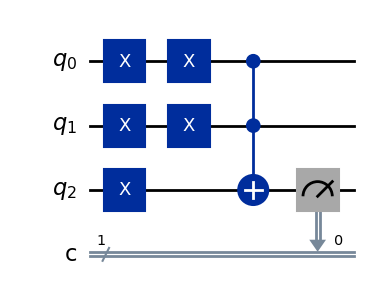

In [12]:
qc = state_prep(True, True)
qc = predictor(qc)
qc.draw("mpl")

That first block (or layer) of $X$ gates is capturing the default case: the $CCX$ gate will emit $\ket{1}$ on qubit $q_3$ as all qubits are currently in the $\ket{1}$ state. Per our state preparation function, if the passenger is either male or an adult, we add an $X$ gate, returning the state of that qubit to $\ket{0}$ and thus causing the $CCX$ gate to emit $\ket{0}$. We map $\ket{0}$ to the negative outcome (did not survive), and $\ket{1}$ to the positive outcome (did survive).

If we execute this circuit we get the following:

In [13]:
sampler = StatevectorSampler()
job = sampler.run([qc], shots=1)

#note we didn't explicitly add a measurement, so the default c is used
dist = job.result()[0].data["c"].get_counts()
dist

{'1': 1}

We now pass the real test data, and then execute our circuit $k$ times (called shots) to produce a probability distribution over the output, and apply a threshold rule (similar to logistic regression) to derive the prediction.

We'll need to switch between different ways to execute our quantum program, so for now, we'll pull the sampler outside of our function.

In [14]:
backend = StatevectorSampler()

In [15]:
def quantumRuleModel(df):
    
    q_predictions = [False] * df.shape[0]
    i = 0
    for _, row in df.iterrows():
        q_predictions[i] = basicQRuleClassifier(row)
        i += 1

    return q_predictions

def basicQRuleClassifier(x):
    qc = state_prep(x['Female'], x['Below18'])
    qc = predictor(qc)
    job = backend.run([qc], shots=1024)
    dist = job.result()[0].data["c"].get_counts()
    if '0' in dist and dist['0'] >= 512:
        return False
    else:
        return True

Now we test, and see our performance is the same (as expected) as the classical rule-based model.

In [16]:
Y_pred = quantumRuleModel(X_test)
acc_rules = round(accuracy_score(Y_test, Y_pred) * 100, 2)
acc_rules

75.98

## Inferencing via the Cloud

We need to be a little careful here, as things can get expensive quite quickly. You'll also need to insert your own API keys, but for illustrative purposes, let's consider the simple case of each possible permutation:

In [17]:
df = pd.DataFrame({
    "Female": [False, False, True, True],
    "Below18": [False, True, False, True]
})

df.head()

,Female,Below18
0,False,False
1,False,True
2,True,False
3,True,True


In [ ]:
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

workspace = Workspace ( 
    resource_id = "", # Add your resource_id 
    location = ""  # Add your workspace location (for example, "westus") 
)

provider = AzureQuantumProvider(workspace)

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

If we now change our backend (this time to a cloud accessible simulator) we can deploy our model on the Azure Quantum Cloud. Note that all we would need to do to deploy to a real device is change how we define our backend. 

We also need to change (subtly) how we access our results data, so redefine our basic classification function.

In [19]:
backend = provider.get_backend("rigetti.sim.qvm")

def basicQRuleClassifier(x):
    qc = state_prep(x['Female'], x['Below18'])
    qc = predictor(qc)
    job = backend.run([qc], shots=1024)
    dist = job.result().get_counts(qc)
    if '0' in dist and dist['0'] >= 512:
        return False
    else:
        return True

If we rerun our simple model evaluation, it will now be deployed on the Azure cloud simulator instead of running locally. 

In [20]:
Y_pred = quantumRuleModel(df)
print(Y_pred)

...............................[False, True, True, True]


If we pass the whole test set instead, we should see similar results (as the simulator is error free). Note that this will deploy one job per row of data, so it takes a while to run. If you deploy it on a real machine, be careful you do not consume all of your free-tier resources.

Obviously, we could also modify our ```basicQRuleClassifer``` function to return the counts instead (or as well) if we wanted to review / inspect the *confidence* of the rule. If this were run on a real device, we wouldn't get 100% agreement (due to noise). In this case, the number of shots (how many times the program / circuit is run) is high enough that any deviation from the expected result (here at least) wouldn't cause a problem. However, in more complex settings, this may not be the case.

## Using basic built-in QML Qiskit Components

We'll start with a standard *off the shelf* style implementation of a quantum neural network. A QNN actually isn't a neural network, but it shares many ideas that look familiar to a classical neural network:
- it has trainable paramters
- we use a classical optimiser (even ones that can be used on a classical neural network)
- the visual representation looks *similar* to the idea of layers
- we can (but don't have to) train via a gradient
- our final prediction layer is sort of similar to the idea of a soft max

Aside from these convenient conceptual similarities, a QNN is a **fundamentally different** form of machine learning.

The components that we need to discuss to form the architecture for the QNN are:
- feature map: represents the transformation from a classical encoding to a quantum encoding of the data. This can also sometimes be referred to as a quantum embedding.
- ansatz: a parameterised *template* quantum program that captures the functional learning of the QNN
- optimiser: to tune the classical parameters

We'll start with built in Qiskit functions, and explore some differences, then look at how to define custom components.

Finally, the idea of *architecture search* from neural networks also applies to QML - the process of finding a good QNN architecture is effectivey a search process over a massive design space. This is also becoming a very common area of the literature, for more details see: https://www.nature.com/articles/s41534-022-00570-y

### Encoding Data: feature maps

The naive approach here is to map 1 feature to 1 qubit. We don't have to do this, but it's a nice simplification initially. 

We have 5 features, so that would mean 5 qubits. However, we'll start with just the two numeric features as well, to keep things simple, and build up from there.

As a general comment, the power of quantum is the ability to scale in the number of qubits, but the challenge is using more qubits effectively:
- more qubits means more entanglement
- more entanglement means increased circuit depth
- increased circuit depth means needing better strategies to deal with errors and noise

Similarly, the computational complexity of simulating the quantum systems scales quadratically with the number of qubits. 

There are hard limits to what your laptop can do. Modern day laptops can handle the simlation of only 10-15 qubit systems. We can increase this maximally to around 25-30 with some tricks in memory management etc. Incidentally, running on an insitutional HPC environment will not really do much more than add a handfull of qubits.

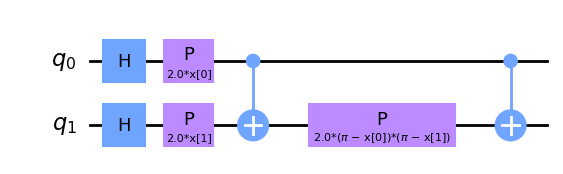

In [22]:
X_train_num = pd.DataFrame(MinMaxScaler().fit_transform(X_train.select_dtypes(include='number')))
X_test_num = pd.DataFrame(MinMaxScaler().fit_transform(X_test.select_dtypes(include='number')))

num_features = X_train_num.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Other considerations:

**Reps:**
- Each *rep* is like a layer in a (Q)NN
- As we increase the number of layers, we also increased the propensity for NISQ-like errors to compound and cause problems. 
- In an error-free setting (such as the state vector simulator) we can easily fool ourselves into thinking more layers means better
- In a NISQ setting, we want to minimise circuit depth: noise (from error) is bad, but we can tolerate some noise! 
- More reps means more parameters (here, basically model weights) to optimise -- these weights are different to the feature parameters from the Feature Map

**Optimiser:**
- There are many options, and each option has its own parameters (i.e. effectively hyperparameters) to consider
- There are progressively more and more options being developed
- In the early days (so 2020/1) optimisers were more general purpose, but recently we are seeing optimisers actively targetting the use case of QNNs.

### Ansatz

We're going to use one of the most common starting points: RealAmplitudes. We'll also (for ease of illustration) use only 1 rep too. For the optimiser, we'll use another common choice: COBLYA. Why? It's not gradient based, so a lot faster.

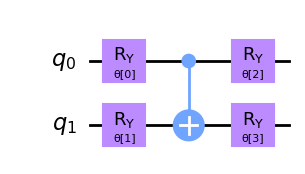

In [23]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [24]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

#array of loss (or similar) values for each iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

/var/folders/0m/15hq16r15hv9wdnnpmgb8twh0000gn/T/ipykernel_9912/963346959.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


### Building and Training the QNN

We essentially concatenate the feature map and ansatz, and package this up as a VQC object:

In [25]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

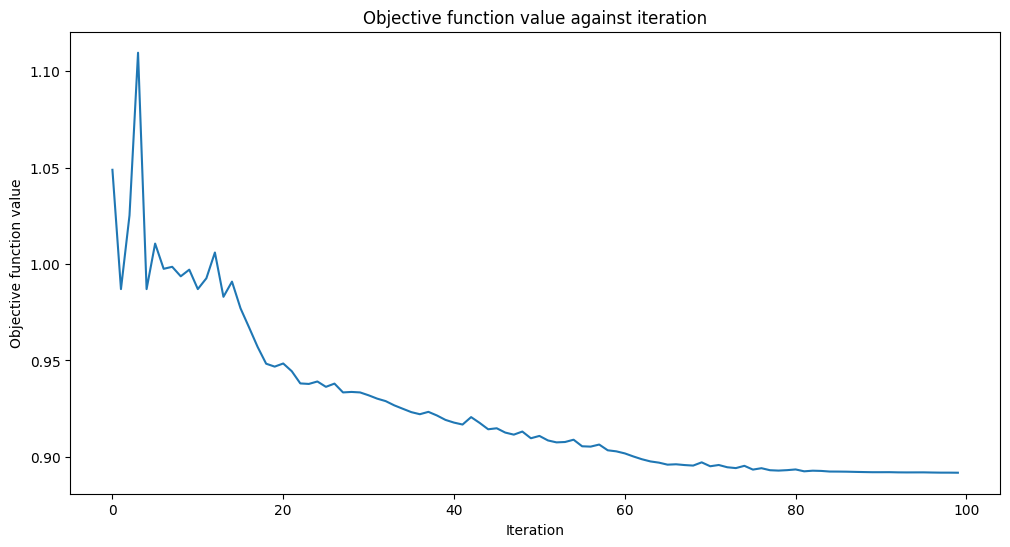

In [26]:
vqc.fit(X_train_num, Y_train.array)

In [27]:
train_score_q4 = vqc.score(X_train_num, Y_train)
test_score_q4 = vqc.score(X_test_num, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.66
Quantum VQC on the test dataset:     0.65


65% test accuracy is poor, but still better than random, and we really have constrained our QNN a lot! If we provide it with a little more capacity by increasing our repetitions:

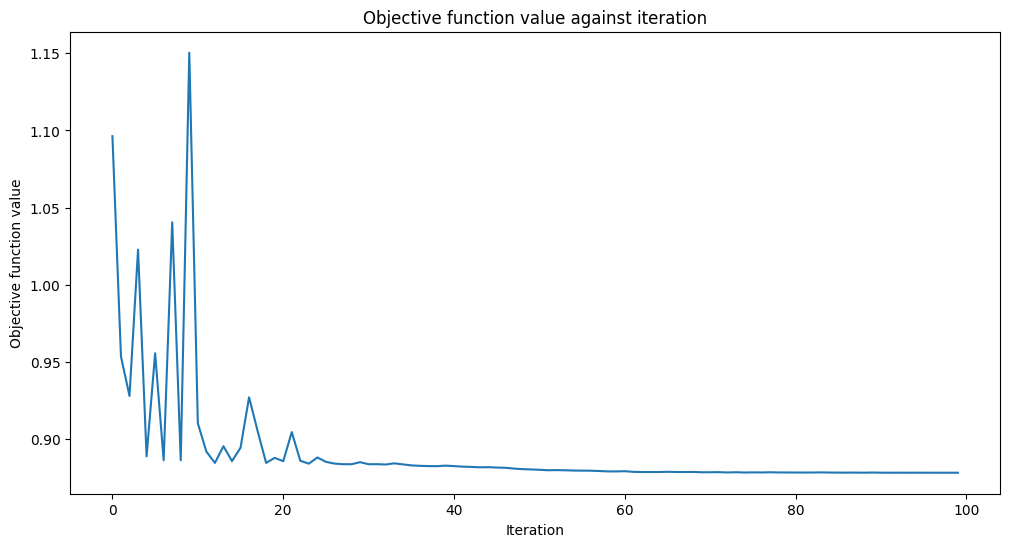

Quantum VQC on the training dataset: 0.67
Quantum VQC on the test dataset:     0.65


In [28]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

vqc.fit(X_train_num, Y_train.array)

train_score_q4 = vqc.score(X_train_num, Y_train)
test_score_q4 = vqc.score(X_test_num, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

## Exploring the QNN Architecture 
Increasing the reps and therefore giving the QNN a bit more functional expressivity, hasn't made much difference... there's probably not enough variance captured by the 2 numeric features. So, let's work in the 3 binary variables.

Before this, to cut down on repeated code, a helper function...

### Tidying Up

In [57]:
def trainQNN(featuremap, ansatz, optimiser, training, testing, showGraph=True):
    if (showGraph):
        # clear objective value history
        objective_func_vals = []
        
        vqc = VQC(
            sampler=sampler,
            feature_map=featuremap,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=callback_graph,
        )
    else:
        vqc = VQC(
            sampler=sampler,
            feature_map=featuremap,
            ansatz=ansatz,
            optimizer=optimizer,
        )

    start = time.time()
    vqc.fit(training, Y_train.array)
    elapsed = time.time() - start

    train_score_q4 = vqc.score(training, Y_train)
    test_score_q4 = vqc.score(testing, Y_test)

    parameters = vqc.circuit.num_parameters

    return train_score_q4, test_score_q4, elapsed, parameters

To use our binary variables, we'll need to encode them differently if we want to use the built in feature map. Of course we can do things ourselves instead if we want more control. While we're at it, we'll scale ``PClass`` too. Obviously there is an amount of information loss in what we're doing here though.

In [30]:
X_train_q = X_train
X_test_q = X_test

X_train_q["Below18"] = X_train["Below18"].map({False: 0, True: 1})
X_train_q["IsAlone"] = X_train["IsAlone"].map({False: 0, True: 1})
X_train_q["Female"] = X_train["Female"].map({False: 0, True: 1})

X_test_q["Below18"] = X_test["Below18"].map({False: 0, True: 1})
X_test_q["IsAlone"] = X_test["IsAlone"].map({False: 0, True: 1})
X_test_q["Female"] = X_test["Female"].map({False: 0, True: 1})		

X_train_q["Pclass"] = scaler.fit_transform(X_train[["Pclass"]])
X_test_q["Pclass"] = scaler.fit_transform(X_test[["Pclass"]])

X_train_q.head()

,Pclass,Below18,IsAlone,Female,scaled_fare
331,0.0,0,1,0,0.055628
733,0.5,0,1,0,0.025374
382,1.0,0,1,0,0.015469
704,1.0,0,0,0,0.015330
813,1.0,1,0,1,0.061045


## Functional Expressivity

We can now play a little with the reps parameters, and we'll slowly see that as we increase these (in both the feature map and ansatz) our model will (well should!) gradually increase in performance. However, so too, will the time needed to train it. In fact, we can also see that the model below (i.e. with 3 reps in the feature map, and 3 reps in the ansatz) hasn't yet fully converged, so we may need to increase the number of iterations in the optimiser for maximal performance of this architecture.

In [56]:
num_features = X_train_q.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=3)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

# clear objective value history
objective_func_vals = []

s1, s2, runtime, p = trainQNN(feature_map, ansatz, optimizer, X_train_q, X_test_q, True)
print(f"Quantum VQC on the training dataset: {s1:.2f}")
print(f"Quantum VQC on the test dataset:     {s2:.2f}")
print(f"Runtime:                             {runtime:.2f}")
print(f"Parameters:                          {p}")

Quantum VQC on the training dataset: 0.67
Quantum VQC on the test dataset:     0.69
Runtime:                             618.39
Parameters:                          25
Depth:                               2


Getting better: into the 70s% now. However, we are still not improving upon our basic rule-based model. So we need to explore the architecture design space. This means essentially investigating the following components of our model:
1. The feature map, its reps, and data loading strategies
2. The choice of ansatz, and its reps
3. The choice of optimiser, and its associated parameters (e.g. iterations).

## Defining our own Ansätze and Feature Maps and Exploring different QNN Architectures

We'll define a few ansätze and feature maps ourself, as this is useful to know how to do should you read a paper and find a circuit diagram / architecture you want to try out.

These have obviously been chosen to show a range of performance, and illustrate that there is no free lunch in QML either!

We're going to simplify things a little here and make some assumptions about the number of qubits and features we use. It's being fixed to 5, with 1 feature per qubit. For reasons of time in the tutorial, we're not going to extend beyond this. However, making some modifications to explore a larger architecture space shouldn't be difficult.

We also notice that some models trained so far have not really converged after 100 iterations. We're going to explore a few different architectures and show the difference some choices make: feature map, ansatz, and optimizer choice.

Ansätze (common ones you'll see in **exploration** style papers):
- real amplitudes
- efficient SU2
- hardware efficient
- quantum convolutional
- swap ansatz

Feature Maps (also fairly common in papers):
- angle encoding
- z feature map
- zz feature map
- pauli rotation feature map

Optimisers:
- COBYLA
- SPSM

Note you could add ADAM here, but the runtime will be somewhat excessive.

We'll vary the number of layers a little at least as we don't really want 1000s of models to try and compare.

In [63]:
def real_amplitudes(num_qubits=3, layers=3):
    qc = QuantumCircuit(num_qubits, 1) 
    parameters = []
    
    for l in range(layers):
        for i in range(num_qubits):
            theta = Parameter(f'θ_{l}_{i}')
            parameters.append(theta)
            qc.ry(theta, i)
        
        for i in range(num_qubits):
            qc.cx(i, (i + 1) % num_qubits)
    
    qc.measure(0, 0)
    
    return qc
    
def eff_su2(num_qubits=3, layers=3):
    qc = QuantumCircuit(num_qubits, 1)  
    parameters = []
    
    for l in range(layers):
        for i in range(num_qubits):
            theta = Parameter(f'θ_{l}_{i}')
            parameters.append(theta)
            qc.ry(theta, i)
            qc.rz(theta, i)
        for i in range(num_qubits):
            qc.cx(i, (i + 1) % num_qubits)
    
    qc.measure(0, 0)
    
    return qc

def hardware_efficient(num_qubits=3, layers=3):

    qc = QuantumCircuit(num_qubits, 1)
    parameters = []
    
    for l in range(layers):
        for i in range(num_qubits):
            theta1 = Parameter(f'θ_{l}_{i}_1')
            theta2 = Parameter(f'θ_{l}_{i}_2')
            theta3 = Parameter(f'θ_{l}_{i}_3')
            parameters.extend([theta1, theta2, theta3])
            
            qc.rz(theta1, i)
            qc.ry(theta2, i)
            qc.rz(theta3, i)
        
        if l < layers - 1:
            for i in range(num_qubits-1):
                qc.cx(i, i+1)
        
    qc.measure(0, 0)
    return qc

def quantum_convolutional(num_qubits=4, layers=2):

    qc = QuantumCircuit(num_qubits, 1)
    parameters = []
    
    #initial rotation layer
    for i in range(num_qubits):
        theta = Parameter(f'θ_init_{i}')
        parameters.append(theta)
        qc.ry(theta, i)
    
    #convolutional layers
    for l in range(layers):
        #two-qubit convolutions
        for i in range(0, num_qubits-1, 2):
            theta1 = Parameter(f'θ_conv_{l}_{i}_1')
            theta2 = Parameter(f'θ_conv_{l}_{i}_2')
            parameters.extend([theta1, theta2])
            
            qc.cx(i, i+1)
            qc.rz(theta1, i+1)
            qc.cx(i, i+1)
            qc.ry(theta2, i)
        
        #shift and repeat (offset by 1)
        for i in range(1, num_qubits-1, 2):
            theta1 = Parameter(f'θ_conv_{l}_{i}_1')
            theta2 = Parameter(f'θ_conv_{l}_{i}_2')
            parameters.extend([theta1, theta2])
            
            qc.cx(i, i+1)
            qc.rz(theta1, i+1)
            qc.cx(i, i+1)
            qc.ry(theta2, i)
    
    #rotation layer
    for i in range(num_qubits):
        theta = Parameter(f'θ_final_{i}')
        parameters.append(theta)
        qc.ry(theta, i)
    
    qc.measure(0, 0)
    return qc
    
def swap_ansatz(num_qubits=3, layers=2):
  
    qc = QuantumCircuit(num_qubits, 1)
    
    for i in range(num_qubits):
        theta = Parameter(f'θ_init_{i}')
        qc.ry(theta, i)
    
    for l in range(layers):
        for i in range(0, num_qubits-1, 2):
            theta = Parameter(f'θ_swap_{l}_{i}')
            
            qc.cx(i, i+1)
            qc.ry(theta, i+1)
            qc.cx(i+1, i)
            qc.ry(theta, i)
            qc.cx(i, i+1)
        
        if num_qubits > 2:
            for i in range(1, num_qubits-1, 2):
                theta = Parameter(f'θ_swap_{l}_{i}')
                
                qc.cx(i, i+1)
                qc.ry(theta, i+1)
                qc.cx(i+1, i)
                qc.ry(theta, i)
                qc.cx(i, i+1)
    
    for i in range(num_qubits):
        theta = Parameter(f'θ_final_{i}')
        qc.ry(theta, i)
    
    qc.measure(0, 0)
    return qc


def angle_encode_features(num_qubits, feature_dim):

    params = ParameterVector('x', feature_dim)
    circuit = QuantumCircuit(num_qubits)
    
    for i in range(feature_dim):
        qubit_idx = i % num_qubits
        circuit.ry(params[i] * np.pi, qubit_idx)
    
    for i in range(num_qubits-1):
        circuit.cx(i, i+1)
    
    return circuit
    
def z_feature_map(num_qubits,feature_dim):

    params = ParameterVector('x', feature_dim)
    circuit = QuantumCircuit(num_qubits)
    
    circuit.h(range(num_qubits))
    
    for i in range(num_qubits):
        qubit_idx = i % num_qubits
        circuit.rz(params[i] * np.pi, qubit_idx)


    return circuit
    
def zz_feature_map(num_qubits, feature_dim):
    

    params = ParameterVector('x', feature_dim)
    circuit = QuantumCircuit(num_qubits)
    
    circuit.h(range(num_qubits))
    
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            #  product of two parameters to encode interactions
            param_idx_i = i % feature_dim
            param_idx_j = j % feature_dim
            circuit.cx(i, j)
            circuit.rz((np.pi / 2) * (params[param_idx_i] + params[param_idx_j]), j)

            circuit.cx(i, j)

    return circuit
    
def pauli_feature_map(num_qubits, feature_dim):
    params = ParameterVector('x', feature_dim)
    circuit = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        qubit_idx = i % num_qubits
        circuit.rx(params[i], qubit_idx)
        circuit.ry(params[i], qubit_idx)
        circuit.rz(params[i], qubit_idx)

    return circuit


## Exploring our Circuit Search Space

We can visualise any combination of feature map and ansatz just by concatenating our circuits to see what our VQC architecture will be, for example (but you can explore as you see fit to).

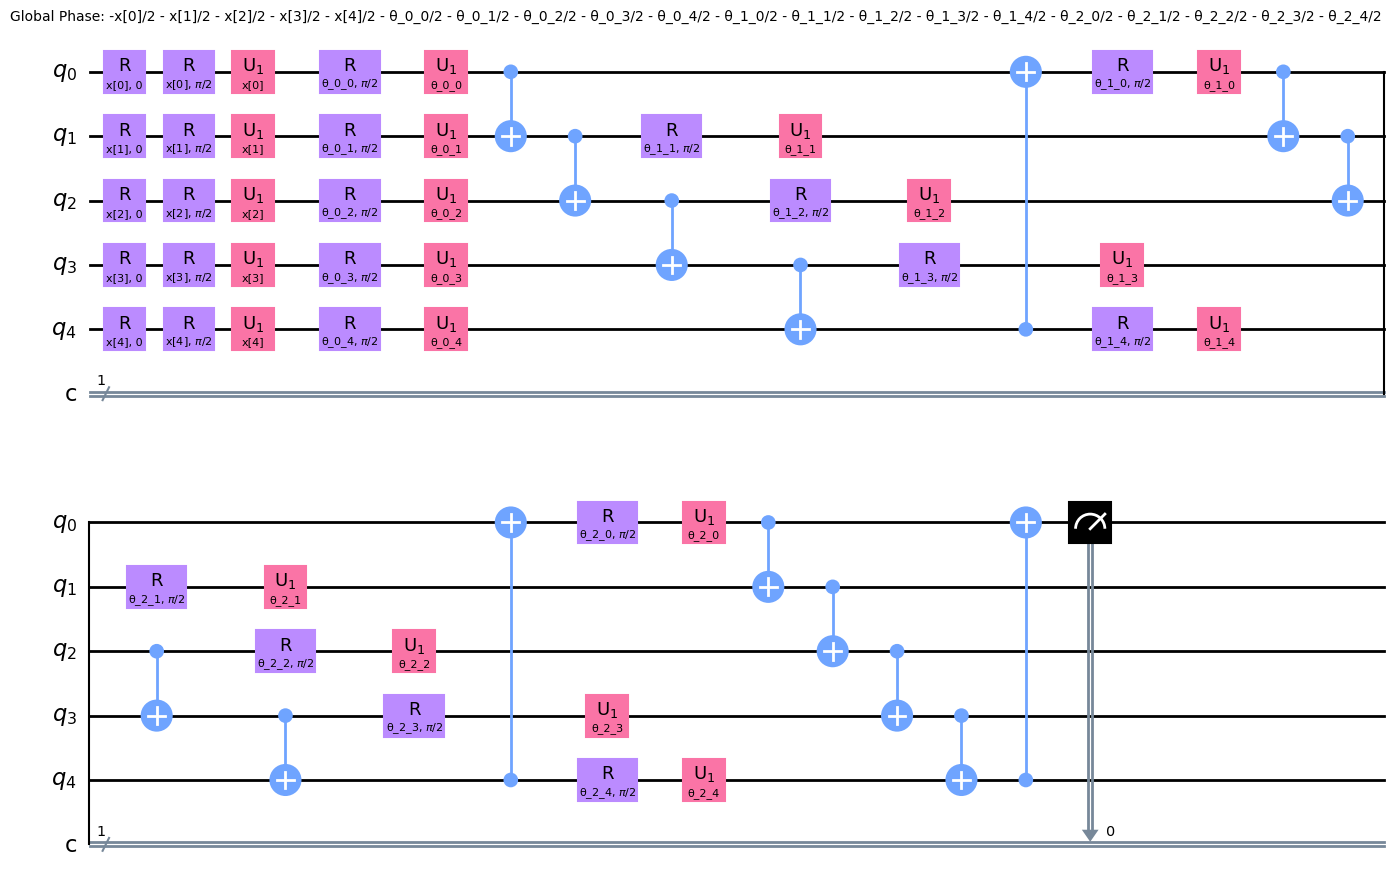

In [89]:
qc = QuantumCircuit(5)
qc = qc.compose(pauli_feature_map(5, 5), qubits=[0,1,2,3,4])
qc = qc.compose(eff_su2(5, 3), qubits=[0,1,2,3,4])

qc.decompose().draw(output="mpl", style="clifford", fold=20)

## Brute Forcing (sort of) the Architecture Search

We know some of these might not have converged, but we'll take the top few and see if giving them a little more time with the optimizer helps out.

Note that if we run the block of code above a few times, we would have a better indication of the top models from a performance stability perspective, as performance can vary, sometimes quite significantly especially if the combination of data prep, feature map, ansatz combination is not stable or well suited to the dataset.

Based on the above, some of the best models are (roughly as we also want a little variation too):
1. angle_encode_features+eff_su2(6 layers w/COBYLA) -> 0.80
2. angle_encode_features+swap_ansatz(5 layers w/COBYLA) -> 0.82
3. z_feature_map+swap_ansatz(5 layers w/COBYLA) -> 0.80
4. zz_feature_map+hardware_efficient(3 layers w/COBYLA) -> 0.80
5. pauli_feature_map+eff_su2(6 layers w/COBYLA) -> 0.81
6. angle_encode_features+real_amplitudes(2 layers w/SPSA) -> 0.79
7. zz_feature_map+eff_su2(4 layers w/SPSA) -> 0.79
8. angle_encode_features+quantum_convolutional(3 layers w/SPSA) -> 0.74

Note a few additional observations:
- There is a fairly obvious correlation between training time and the number of parameters
- Compared to classical neural networks, the number of parameters is **REALLY** low
- Some of the times are **high** because computation was paused and not run in one continuous session
- More is not always better, sometimes adding more layers did little more than increase the training time
- Some combinations (with this dataset, and data preparation strategy) just don't work

In [64]:
search_results = []

feature_map_list=[angle_encode_features,z_feature_map,zz_feature_map,pauli_feature_map]
ansatz_list=[real_amplitudes, eff_su2, hardware_efficient, quantum_convolutional, swap_ansatz]
optimizer_list=[COBYLA, SPSA]

n_iter = 100
layers_ansatz = [2, 3, 4, 5, 6]

for optim in optimizer_list:
    for f_map in feature_map_list:
        for ansatz in ansatz_list:
            for l in layers_ansatz:
                train_acc, test_acc, r, p = trainQNN(f_map(5, 5), ansatz(5, l), optim(maxiter=n_iter), X_train_q, X_test_q, False)
                print(f"{f_map.__name__}+{ansatz.__name__}({l} layers w/{optim.__name__}) -> {test_acc:.2f}({train_acc:.2f}) ran for {r:.2f} -- {p} params")
                search_results.append({
                    "Feature Map": f_map.__name__,
                    "Ansatz": ansatz.__name__,
                    "Layers": l,
                    "Optimiser": optim.__name__,
                    "Train Acc": train_acc,
                    "Test Acc": test_acc,
                    "Runtime": r,
                    "Params": p,
                })

search_results_df = pd.DataFrame(search_results)
search_results_df

angle_encode_features+real_amplitudes(2 layers w/COBYLA) -> 0.78(0.79) ran for 120.74 -- 15 params
angle_encode_features+real_amplitudes(3 layers w/COBYLA) -> 0.78(0.79) ran for 159.99 -- 20 params
angle_encode_features+real_amplitudes(4 layers w/COBYLA) -> 0.78(0.79) ran for 198.58 -- 25 params
angle_encode_features+real_amplitudes(5 layers w/COBYLA) -> 0.78(0.78) ran for 238.47 -- 30 params
angle_encode_features+real_amplitudes(6 layers w/COBYLA) -> 0.76(0.79) ran for 277.81 -- 35 params
angle_encode_features+eff_su2(2 layers w/COBYLA) -> 0.78(0.78) ran for 165.80 -- 15 params
angle_encode_features+eff_su2(3 layers w/COBYLA) -> 0.75(0.76) ran for 229.07 -- 20 params
angle_encode_features+eff_su2(4 layers w/COBYLA) -> 0.74(0.78) ran for 285.68 -- 25 params
angle_encode_features+eff_su2(5 layers w/COBYLA) -> 0.75(0.77) ran for 341.05 -- 30 params
angle_encode_features+eff_su2(6 layers w/COBYLA) -> 0.80(0.80) ran for 400.80 -- 35 params
angle_encode_features+hardware_efficient(2 layers 

,Feature Map,Ansatz,Layers,Optimiser,Train Acc,Test Acc,Runtime,Params
0,angle_encode_features,real_amplitudes,2,COBYLA,0.785112,0.776536,120.744590,15
1,angle_encode_features,real_amplitudes,3,COBYLA,0.794944,0.782123,159.986970,20
2,angle_encode_features,real_amplitudes,4,COBYLA,0.787921,0.782123,198.577053,25
3,angle_encode_features,real_amplitudes,5,COBYLA,0.780899,0.776536,238.473340,30
4,angle_encode_features,real_amplitudes,6,COBYLA,0.785112,0.759777,277.811899,35
...,...,...,...,...,...,...,...,...
195,pauli_feature_map,swap_ansatz,2,SPSA,0.787921,0.782123,249.932711,23
196,pauli_feature_map,swap_ansatz,3,SPSA,0.787921,0.782123,324.811719,27
197,pauli_feature_map,swap_ansatz,4,SPSA,0.778090,0.748603,397.164836,31
198,pauli_feature_map,swap_ansatz,5,SPSA,0.789326,0.782123,470.739856,35


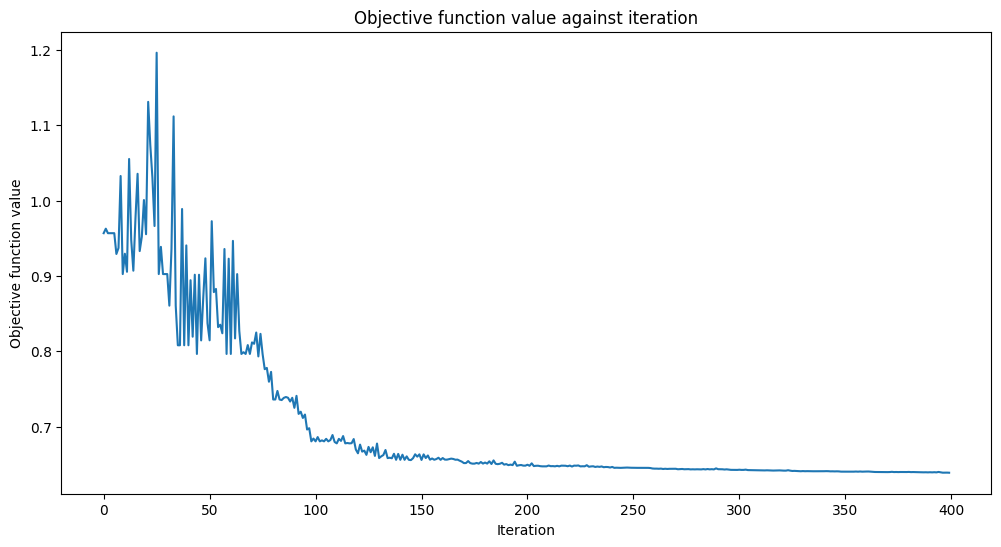

Quantum VQC on the training dataset: 0.80
Quantum VQC on the test dataset:     0.79
Runtime:                             756.86


In [80]:
objective_func_vals = []
        
vqc_1 = VQC(
    sampler=sampler,
    feature_map=angle_encode_features(5, 5),
    ansatz=swap_ansatz(5, 5),
    optimizer=COBYLA(maxiter=400),
    callback=callback_graph,
)

start = time.time()
vqc_1.fit(X_train_q, Y_train.array)
elapsed = time.time() - start

train_score_q1 = vqc_1.score(X_train_q, Y_train)
test_score_q1 = vqc_1.score(X_test_q, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q1:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q1:.2f}")
print(f"Runtime:                             {elapsed:.2f}")

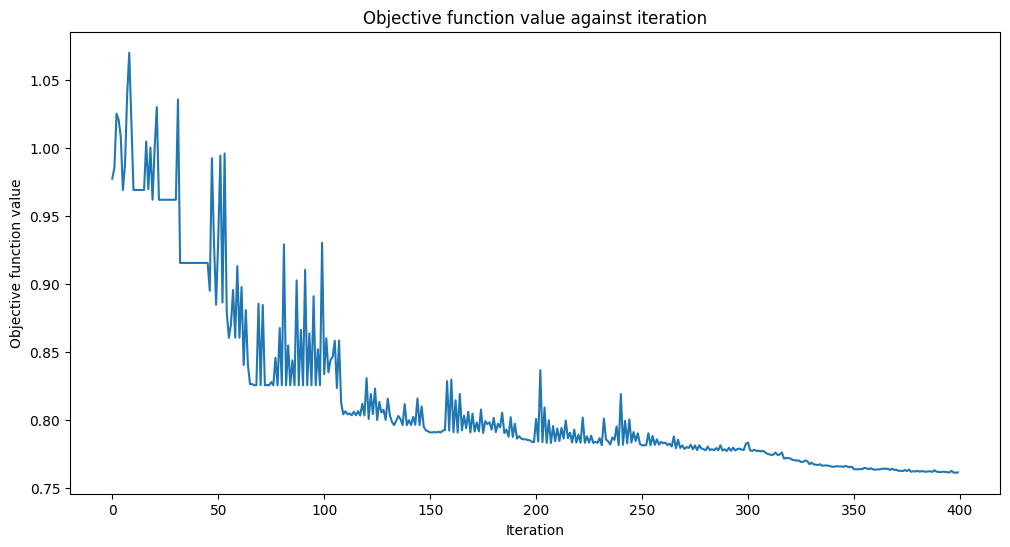

Quantum VQC on the training dataset: 0.80
Quantum VQC on the test dataset:     0.81
Runtime:                             617.68


In [81]:
objective_func_vals = []
        
vqc_2 = VQC(
    sampler=sampler,
    feature_map=zz_feature_map(5, 5),
    ansatz=hardware_efficient(5, 3),
    optimizer=COBYLA(maxiter=400),
    callback=callback_graph,
)

start = time.time()
vqc_2.fit(X_train_q, Y_train.array)
elapsed = time.time() - start

train_score_q2 = vqc_2.score(X_train_q, Y_train)
test_score_q2 = vqc_2.score(X_test_q, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q2:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2:.2f}")
print(f"Runtime:                             {elapsed:.2f}")

In [85]:
objective_func_vals = []
        
vqc_3 = VQC(
    sampler=sampler,
    feature_map=angle_encode_features(5, 5),
    ansatz=quantum_convolutional(5, 3),
    optimizer=SPSA(maxiter=400),
    callback=callback_graph,
)

start = time.time()
vqc_3.fit(X_train_q, Y_train.array)
elapsed = time.time() - start

train_score_q3 = vqc_3.score(X_train_q, Y_train)
test_score_q3 = vqc_3.score(X_test_q, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q3:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q3:.2f}")
print(f"Runtime:                             {elapsed:.2f}")

Quantum VQC on the training dataset: 0.75
Quantum VQC on the test dataset:     0.74
Runtime:                             1856.59


# Concluding Remarks, Further Work, and Final Considerations

- We more or less equaled the performance observed in https://arxiv.org/pdf/2509.00916 in the 80-82% region.
- We can improve on our performance by looking more at the data encoding strategy, and using other trick e.g. factor analysis, scaling by $\pi$ instead etc.
- We could explore other feature maps, ansätze and optimisers
- We could explore things like data-reuploading

However, as a start into the domain of QML, we hope this allows you to get started and explore this space. If you find a mistake in this notebook or want to extend it somehow, please do get in touch.

## Extensions
1. A natural extension would be to consider noise, as we've explored only "perfect" computations. This is not realistic. However, because training on a real device is (prohibitively) expensive, the best we can do is use calibrated noise models of the real machines. Qiskit defines these as "fake" backends, and there is (usually) one of these available per real IBM device.
2. Qiskit, while great for getting started is quite cumbersome (and constantly changing!) -- this is the sixth time this tutorial has been written in 3 years. A natural progression from Qiskit, would be to apply the learnings to PennyLane: https://pennylane.ai
3. More datasets...
4. An emerging trend in the QML literature is the use of hybrid models, where a pretrained model is combined with a QNN. Start reading for this area would be: http://arxiv.org/abs/1912.08278 -- it's a very interesting area of current research